# Nearest neighbors

Last week we learned about logistic regression. This was the first classification technique we learned. However, one limitation of logistic regression is that the input variables must be continuous. What can we do if we have categorical variables that we want to train our model with? One model that handles categorical variables as well as continuous variables is nearest neighbors. This week we will learn about nearest neighbors, along with other ways to deal with categorical variables.

### Imports

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

### Data loading

In this notebook we will continue working with data from an Internet Service Provider (ISP). Below is a brief refresher on some of the columns.
- **customerID:** A unique ID for each customer
- **Partner:** Whether or not the customer has a partner (spouse/significant other)
- **tenure:** How many months the person has been a customer
- **MonthlyCharges:** How much (in dollars) the customer is charged every month
- **TotalCharges:** How much the customer has been charged over their lifetime with the ISP
- **Churn:** Whether or not a customer leaves the ISP (i.e. cancels their service)

In [ ]:
df = pd.read_csv('data/isp_customers.csv')

In [ ]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

We'll do the same cleaning as we did last week.

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 
df = df.dropna(how='any')

## Label encoding

Most machine learning models only work with numerical data. It is fine for the numerical data to be categorical, but it must be numerical. Therefore, almost no model can work with vlaues like "Female" or "No phone service". Therefore the first step when dealing with categorical data is to "encode" your categorical data to make it numerical. All that encoding is is changing data to numbers. Let's encode the gender column first. We'll do this "by hand", and later do it in a more efficient way using sklearn.

The simplest "by hand" way to encode data is to make a Python dictionary which maps the text values to numerical values. So for example, we could set Female to be 0 and Male to be 1.

In [ ]:
gender_map = {'Female': 0, 'Male': 1}

We can then use the Pandas `.map()` function. This takes in a dictionary (or a function) and applies is to every row. It then replaces the value in that row with the result from the function, or the value in the dictionary. That may sound complicated, but it's actually very simple. By supplying `.map()` with the `gender_map` above for the column `gender`, it will replace every `'Female'` with `0` and every `'Male'` with `'1'`.

In [ ]:
df['gender'] = df['gender'].map(gender_map)

In [ ]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG       0              0     Yes         No       1           No   
1  5575-GNVDE       1              0      No         No      34          Yes   
2  3668-QPYBK       1              0      No         No       2          Yes   
3  7795-CFOCW       1              0      No         No      45           No   
4  9237-HQITU       0              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

That's it! We can do the same thing for any column we want. If you want to avoid typing all values by hand (perhaps there are dozens of them, or perhaps each one is very long), you can also use `enumerate` to save you time. What `enumerate` does is return each item in a list, along with a counter. Here's an example:

In [ ]:
for x, y in enumerate(['a', 'b', 'c']):
    print(x, y)

0 a
1 b
2 c


As you can see, the first thing `enumerate` returns is the counter. The first item is in the zeroth place, so it returns a zero. It also returns what that item is (`'a'` in our case). It then repeats this for all items.

We can use this to our advantage to make our own maps without having to write out all items by hand. Let's do this for the column `MultipleLines`.

In [ ]:
multiple_lines_map = {item: i for i, item in enumerate(df['MultipleLines'].unique())}

In [ ]:
multiple_lines_map

{'No phone service': 0, 'No': 1, 'Yes': 2}

Breaking this down, we first `enumerate` all the unique values in the column `MultipleLines`. Then, `enumerate` returns two things: the counter (which we called `i`) and the item (which we called `item`). We then using comprehension to make a dictionary. The key is the item, and the value is the counter. Try doing it for other columns!

In [ ]:
df['MultipleLines'] = df['MultipleLines'].map(multiple_lines_map)

In [ ]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG       0              0     Yes         No       1           No   
1  5575-GNVDE       1              0      No         No      34          Yes   
2  3668-QPYBK       1              0      No         No       2          Yes   
3  7795-CFOCW       1              0      No         No      45           No   
4  9237-HQITU       0              0      No         No       2          Yes   

   MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0              0             DSL             No  ...               No   
1              1             DSL            Yes  ...              Yes   
2              1             DSL            Yes  ...               No   
3              0             DSL            Yes  ...              Yes   
4              1     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

While this works great, it has some problems. One problem is that if you have to keep track of what a `gender` of 0 means, what a `MultipleLines` of 2 means, and so forth. Also, if you wanted to go backwards (i.e. turn `MultipleLines = 0` into `'No phone service'`), you would need to make a reverse map that turns the numbers back into text. This is totally do-able, but a bit annoying.

Luckily, sklearn has a helper function (surprise!) to help with this. It is called a `LabelEncoder`. A label encoder just does what we did, but it handles all of these steps for us. In order to use a `LabelEncoder`, you must `.fit()` it on the data you want to encode (so likely `df['my_column']`). It can then `.transform()` a column to turn text into numbers. It can also `.inverse_transform()` to turn numbers back into text. Let's try it. 

In [ ]:
contract_le = LabelEncoder()
contract_le.fit(df['Contract'])
df['Contract'] = contract_le.transform(df['Contract'])

In [ ]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG       0              0     Yes         No       1           No   
1  5575-GNVDE       1              0      No         No      34          Yes   
2  3668-QPYBK       1              0      No         No       2          Yes   
3  7795-CFOCW       1              0      No         No      45           No   
4  9237-HQITU       0              0      No         No       2          Yes   

   MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0              0             DSL             No  ...               No   
1              1             DSL            Yes  ...              Yes   
2              1             DSL            Yes  ...               No   
3              0             DSL            Yes  ...              Yes   
4              1     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies Contract  PaperlessBilling  \
0          No          No              No        0               Yes   
1          No          No              No        1                No   
2          No          No              No        0               Yes   
3         Yes          No              No        1                No   
4          No          No              No        0               Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

The `Contract` column has been converted into text. What if we want to go backwards?

In [ ]:
df['Contract'] = contract_le.inverse_transform(df['Contract'])
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG       0              0     Yes         No       1           No   
1  5575-GNVDE       1              0      No         No      34          Yes   
2  3668-QPYBK       1              0      No         No       2          Yes   
3  7795-CFOCW       1              0      No         No      45           No   
4  9237-HQITU       0              0      No         No       2          Yes   

   MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0              0             DSL             No  ...               No   
1              1             DSL            Yes  ...              Yes   
2              1             DSL            Yes  ...               No   
3              0             DSL            Yes  ...              Yes   
4              1     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

And we're back! 

Let's write a `for` loop to go through the columns we want to encode. We'll save each of the encoders into a dictionary so that we can access it later if we need it.

In [ ]:
cat_cols = ['Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaymentMethod', 'Churn']
label_encoder = {}

# Go through each categorical column
for c in cat_cols:
    # Create a new label encoder for this column
    le = LabelEncoder()
    
    # Fit the label encoder on the column data
    le.fit(df[c])
    
    # Transform the column to numeric
    df[c] = le.transform(df[c])
    
    # Save the label encoder to the label_encoder dictionary, indexed by the column name
    label_encoder[c] = le

In [ ]:
df.head()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        1           0       1   
1  5575-GNVDE       1              0        0           0      34   
2  3668-QPYBK       1              0        0           0       2   
3  7795-CFOCW       1              0        0           0      45   
4  9237-HQITU       0              0        0           0       2   

   PhoneService  MultipleLines  InternetService OnlineSecurity  ...  \
0             0              0                0             No  ...   
1             1              1                0            Yes  ...   
2             1              1                0            Yes  ...   
3             0              0                0            Yes  ...   
4             1              1                1             No  ...   

  DeviceProtection TechSupport StreamingTV StreamingMovies Contract  \
0               No          No          No              No        0   
1              Yes          No          No              No        1   
2               No          No          No              No        0   
3              Yes         Yes          No              No        1   
4               No          No          No              No        0   

   PaperlessBilling PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0               Yes             2           29.85         29.85      0  
1                No             3           56.95       1889.50      0  
2               Yes             3           53.85        108.15      1  
3                No             0           42.30       1840.75      0  
4               Yes             2           70.70        151.65      1  

[5 rows x 21 columns]

To make things easier, let's just grab a few columns to work with.

In [ ]:
sub_df = df[['gender', 'SeniorCitizen', 'tenure', 'MultipleLines', 'MonthlyCharges', 'TotalCharges'] + cat_cols]

In [ ]:
sub_df.head()

gender  SeniorCitizen  tenure  MultipleLines  MonthlyCharges  TotalCharges  \
0       0              0       1              0           29.85         29.85   
1       1              0      34              1           56.95       1889.50   
2       1              0       2              1           53.85        108.15   
3       1              0      45              0           42.30       1840.75   
4       0              0       2              1           70.70        151.65   

   Partner  Dependents  PhoneService  InternetService  Contract  \
0        1           0             0                0         0   
1        0           0             1                0         1   
2        0           0             1                0         0   
3        0           0             0                0         1   
4        0           0             1                1         0   

   PaymentMethod  Churn  
0              2      0  
1              3      0  
2              3      1  
3              0      0  
4              2      1

In [ ]:
sub_df.dtypes

gender               int64
SeniorCitizen        int64
tenure               int64
MultipleLines        int64
MonthlyCharges     float64
TotalCharges       float64
Partner              int64
Dependents           int64
PhoneService         int64
InternetService      int64
Contract             int64
PaymentMethod        int64
Churn                int64
dtype: object

## Can we use logistic regression now? <a id="logistic_reg"></a>

We said at the top of this notebook that logistic regression only works with continuous data, not categorical. But you may be wondering, why not just use logistic regression now that all columns are numbers? They may not be *continuous*, but they're still numbers. In fact, you *can* use logistic regression (in that the commands will work). Let's try before moving on.

In [ ]:
# Create the logistic regression object
clf = LogisticRegression()

# Train-test split the data
train_df, test_df = train_test_split(sub_df, test_size=0.3)

# Split up the columns into the input and output
X_cols = ['gender', 'SeniorCitizen', 'tenure', 'MultipleLines', 'MonthlyCharges', 'TotalCharges', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaymentMethod']
y_col = 'Churn'

# Create the training set
X_train = train_df[X_cols]
y_train = train_df[y_col]

# Create the testing set
X_test = test_df[X_cols]
y_test = test_df[y_col]

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Classification report to see how we did
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1559
           1       0.62      0.54      0.57       551

    accuracy                           0.79      2110
   macro avg       0.73      0.71      0.72      2110
weighted avg       0.78      0.79      0.79      2110



This seems reasonable. We are getting decent precision, recall and f1-score. We will keep these results as a baseline. Once we learn about more models in this notebook, we will see how the results compare.

Regardless, it's worth pointing out that *this is a bad model, even if the results look good.* The reason is that logistic regression is really just linear regression in disguise. Recall from last week that logistic regression fits a line $f(x)$ so that $\sigma\Bigl(f(x)\Bigr)$ ($\sigma$ is the sigmoid function) best predicts the probabilities of each class. The line is fit based on the data. However, if we make a scatterplot of, say, `gender` versus `Churn` we get the following:

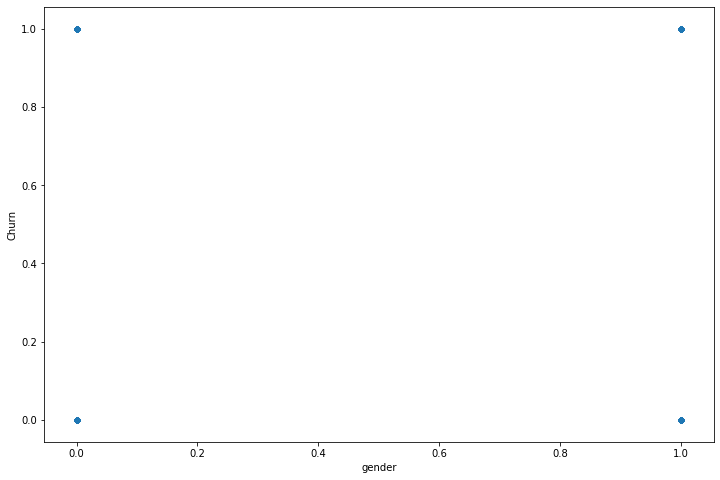

In [ ]:
sub_df.plot(x='gender', y='Churn', kind='scatter', figsize=(12, 8))

How could we possibly fit a line to this? Even though the axes makes it look like the data is continuous, each one only takes values 0 or 1. So, while sklearn *will* gladly fit a line to this (shown below), it is garbage. This illustrates why you need to *understand* what a model is doing, as opposed to simply memorizing commands.

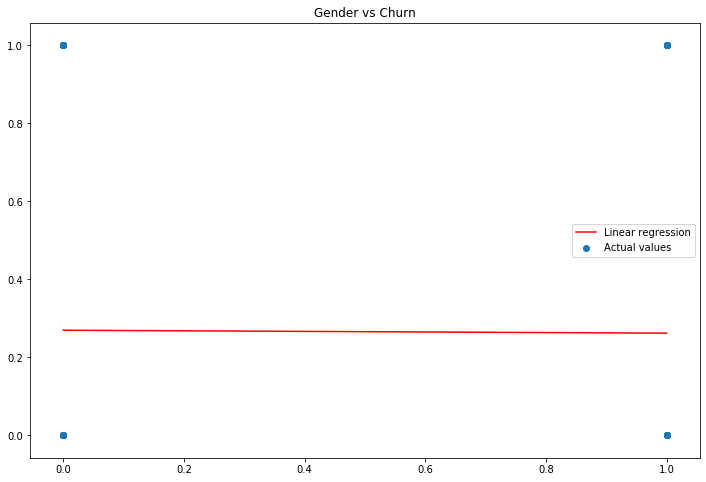

In [ ]:
# Line of best fit for gender vs churn
lr = LinearRegression()
X = sub_df[['gender']]
y = sub_df['Churn']
lr.fit(X, y)

# Plot the scatterplot and the line
fig = plt.figure(figsize=(12, 8))
plt.scatter(X, y, label='Actual values')

X_for_line = np.linspace(0, 1, 2).reshape(-1, 1)
plt.plot(X_for_line, lr.predict(X_for_line), label='Linear regression', color='red')
plt.legend()

plt.title('Gender vs Churn');

What an amazing line of best fit! So in summary, don't do this. Anyone who knows what they are doing would look at this code and say "this person has no idea how logistic regression works."

## Supervised vs unsupervised models <a id="supervised_unsupervised"></a>

Up until this point all models we have learned are what are called "supervised models." By a **supervised model** we mean a model trained by telling it what the ground truth is (the correct labels), and having the model learn to predict these values. You may think that this is the only way we possibly could train a model. After all, how could a model possibly learn to make correct predictions if it doesn't know what the correct answer is! However, consider the following situation: You move to a new country where you don't speak the language. You want to buy a train ticket to go visit another city, however you don't know how much the ticket will cost. Moreover, since you don't speak the language you can't ask anyone how much it costs. However, as you're waiting in line you watch the other people buying tickets. You notice the people in the same line as you all seem to pay around \\$20. Therefore, you decide that you'll also just hand the cashier \\$20, and hopefully that will be the correct amount of money. You don't *know the answer* for how much the ticket will cost. However, by observing *people around you* you are able to *make a prediction*. This is exactly how many unsupervised models work. By an **unsupervised model** we mean a model that learns its form by comparing its predictions to the ground truth.

## Nearest neighbors <a id="nearest_neighbors"></a>

Nearest neighbors is one of the most common unsupervised models. It works by looking at the points closest to it (hence the name "nearest neighbors"), and predicts the same label as those points do. So while nearest neighbors uses the ground truth so that it can see what its neighbors are predicting, it *does not* adjust its predictions based on whether or not it got the correct answer. Let's jump right into an example.

At this point you should be starting to get more comfortable with how sklearn models work. Therefore, we will skip the details of the code below, but ask you to fill in the details yourself using the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

In [ ]:
nn_clf = KNeighborsClassifier()

nn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
nn_clf.predict(X_test)

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
nn_clf.predict_proba(X_test)

array([[0.8, 0.2],
       [0. , 1. ],
       [0.8, 0.2],
       ...,
       [1. , 0. ],
       [0.4, 0.6],
       [0.6, 0.4]])

As you can see, the nearest neighbors model is predicting which class each sample should belong to, along with the probability (if you use `.predict_proba()`). This should look just like the results of logistic regression:

In [ ]:
# Logistic regression predictions
clf.predict(X_test)

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
# Logistic regression predicted probabilities
clf.predict_proba(X_test)

array([[0.62635386, 0.37364614],
       [0.32739281, 0.67260719],
       [0.55533517, 0.44466483],
       ...,
       [0.98057425, 0.01942575],
       [0.52777754, 0.47222246],
       [0.45268345, 0.54731655]])

Before we do any further, let's look at the classification report to see how this new model did.

In [ ]:
y_pred_nn = nn_clf.predict(X_test)
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1559
           1       0.59      0.50      0.54       551

    accuracy                           0.78      2110
   macro avg       0.71      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110



If you look above at the classification report for logistic regression you will see that this nearest neighbors model actually achieves similar results. The f1-scores are very similar, along with precision and recall. However, as we discussed above, logistic regression would be a poor choice of a model, even if the results looked better. Remember that what this nearest neighbors model is doing is looking at *similar ISP customers and making predictions based on those*. Therefore, we are using a model that learns from already existing customers. This is totally logical.

While the initial results from our nearest neighbors model is decent, there is actually more we can do to improve it. For one thing, nearest neighbors makes its predictions by looking at the number of neighbors. How many neighbors is it looking at? If you look at the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) you will see that by default it uses five neighbors. Let's try some different values and see how the results compare.

In [ ]:
# Build models with different number of neighbors used for prediction
for n_neighbors in [1, 5, 10, 15]:
    # Build the classifier
    nn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train it
    nn_clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_nn = nn_clf.predict(X_test)
    
    # Print the classification report
    print(f'{n_neighbors} neighbors')
    print(classification_report(y_test, y_pred_nn))
    print('='*40)

1 neighbors
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1559
           1       0.46      0.49      0.48       551

    accuracy                           0.72      2110
   macro avg       0.64      0.64      0.64      2110
weighted avg       0.72      0.72      0.72      2110

5 neighbors
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1559
           1       0.59      0.50      0.54       551

    accuracy                           0.78      2110
   macro avg       0.71      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

10 neighbors
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1559
           1       0.65      0.39      0.49       551

    accuracy                           0.79      2110
   macro avg       0.73      0.66      0.68      2110
weighted avg       0.77      0.79    

So it seems like the f1-score is best for both classes around 5 neighbors.

One question you should be asking yourself is, "how is the model measuring 'nearest'?" In particular, if you think back to the original data, we had values like "Yes", "No", "Multiple phone lines", etc. So which is closer, "Yes" and "No", or "Yes" and "Multiple phone lines"? It doesn't really make sense to say one is closer than the other, they're just words. By default, nearest neighbors is using the usual Euclidean distance function. So it says that 0 is closer 1 than it is to 2. This is bad for our data, since 0, 1 and 2 are just numbers randomly assigned to each value. If we changed what values we assigned to them we would get different results. Luckily for us, sklearn allows you to pick different [distance functions](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric). We are in the situation of having integer values, so we should pick a function from the "Metrics intended for integer-valued vector spaces" list. Hamming distance is simply the number of neighbors with different values (so, for instance, number of neighbors who don't have "multiple phone lines", divided by the total number of neighbors). Therefore, a point is "close" if this distance is small, and thus if the neighbor has the same values. Let's use that distance function by specifying `metric='hamming'`.

In [ ]:
# Build models with different number of neighbors used for prediction
for n_neighbors in [1, 5, 10, 15]:
    # Build the classifier
    nn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric='hamming')
    
    # Train it
    nn_clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_nn = nn_clf.predict(X_test)
    
    # Print the classification report
    print(f'{n_neighbors} neighbors')
    print(classification_report(y_test, y_pred_nn))
    print('='*40)

1 neighbors
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1559
           1       0.46      0.57      0.51       551

    accuracy                           0.71      2110
   macro avg       0.65      0.67      0.65      2110
weighted avg       0.74      0.71      0.72      2110

5 neighbors
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1559
           1       0.49      0.62      0.54       551

    accuracy                           0.73      2110
   macro avg       0.67      0.69      0.68      2110
weighted avg       0.75      0.73      0.74      2110

10 neighbors
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1559
           1       0.52      0.57      0.54       551

    accuracy                           0.75      2110
   macro avg       0.68      0.69      0.69      2110
weighted avg       0.76      0.75    

While the f1-scores aren't drastically different, we can see that the precision and recall values for each class are often closer together. Therefore, the results our model makes are more reliable, since we don't have to say "if it predicts the customer *will* churn then I'm highly confident in the result, but if it predicts they *won't* churn then it's probably wrong." Again, machine learning is not just about building models that return good metrics. It's about building models for which you can *defend their predictions*. If an internet company is spending tens of millions of dollars based on your predictions, you need to be able to back up your model. Simply saying "it returned a high score" is not good enough.

## Visualizing predictions using PCA <a id="visualizing_preds"></a>

Besides just tables of numbers, it would be nice to *see* what our model is predicting. The problem is that we have twelve input columns and one output column, so we would have to "see" 13 dimensional space. This is why we have to rely so much on metrics to help us "see" how our model is doing. However, we do have a tool at our disposal to help us. **Principal component analysis** (or PCA for short) is a mathematical technique to take a high dimensional vector space, and transform it into a lower dimensional vector space, while preserving the distance between points as much as possible. It's beyond the scope of this course to go into the details of PCA, but here are several resources: [1](https://setosa.io/ev/principal-component-analysis/), [2](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c), [3](https://builtin.com/data-science/step-step-explanation-principal-component-analysis). The short version is that PCA does the best job it can (in a strict mathematical sense) to take data in high dimensions and represent it in lower dimensions in a way that is "as close as possible" to the original data. Sklearn makes PCA very easy. Simply specify how many dimensions you want to reduce it to (referred to as the number of "components") and `.fit()` it to your data, just like you did for your models.

In [ ]:
# Use one of the better models
nn_clf = KNeighborsClassifier(n_neighbors=10, metric='hamming')
nn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='hamming',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
pca = PCA(n_components=2)
pca.fit(df[X_cols])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In order to see the data "transformed" into lower dimensions, use the `.transform()` method.

In [ ]:
X_train_pca = pca.transform(X_train)
X_train_pca

array([[-2149.18993938,    38.88171609],
       [-2264.34862277,   -18.18256247],
       [ 1283.41925878,     3.30003747],
       ...,
       [-2164.00336359,    11.5014036 ],
       [-2208.37301471,    31.39090074],
       [-1357.21923612,    -7.58733048]])

In [ ]:
print(f'Data shape: {X_train.shape} (original) --> {X_train_pca.shape}')

Data shape: (4922, 12) (original) --> (4922, 2)


So we can see that the data went from having 12 columns (dimensions) down to just 2. In order to plot this, we'll split up the data into churning and non-churning customers. We'll print all the non-churning customers as green, and the churning customers as red.

In [ ]:
def split_churn(df):
    nonchurn_df = df[df['Churn'] == 0]
    churn_df = df[df['Churn'] == 1]

    X_nonchurn = nonchurn_df[X_cols]
    y_nonchurn = nonchurn_df[y_col]

    X_churn = churn_df[X_cols]
    y_churn = churn_df[y_col]
    
    return X_nonchurn, y_nonchurn, X_churn, y_churn

In [ ]:
X_train_nonchurn, y_train_nonchurn, X_train_churn, y_train_churn = split_churn(train_df)
X_test_nonchurn, y_test_nonchurn, X_test_churn, y_test_churn = split_churn(test_df)

First let's just PCA the X values for just the training data. We'll peek at the data to see what it looks like, then plot it.

In [ ]:
X_train_pca_nonchurn = pca.transform(X_train_nonchurn)
X_train_pca_churn = pca.transform(X_train_churn)

X_train_pca_nonchurn

array([[-2149.18993938,    38.88171609],
       [ 1283.41925878,     3.30003747],
       [-1593.80623066,   -34.09533561],
       ...,
       [  775.06532704,    -3.0332664 ],
       [-2164.00336359,    11.5014036 ],
       [-1357.21923612,    -7.58733048]])

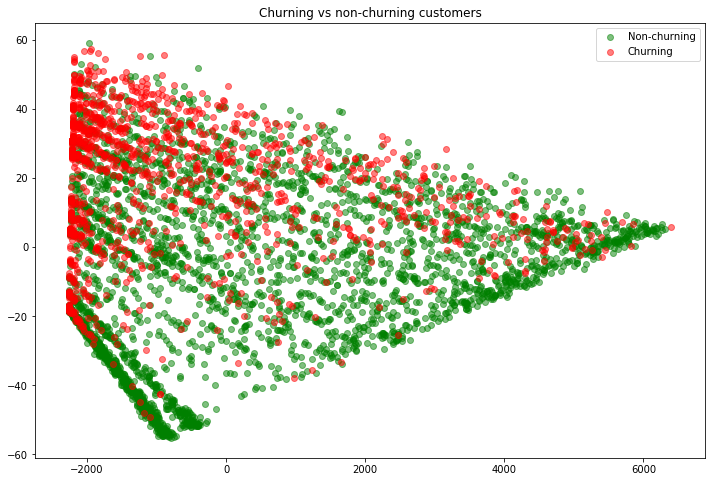

In [ ]:
fig = plt.figure(figsize=(12, 8))
# Get all rows, but just the first/second column
plt.scatter(x=X_train_pca_nonchurn[:, 0], y=X_train_pca_nonchurn[:, 1], label='Non-churning', color='green', alpha=0.5)
plt.scatter(x=X_train_pca_churn[:, 0], y=X_train_pca_churn[:, 1], label='Churning', color='red', alpha=0.5)

plt.legend()
plt.title('Churning vs non-churning customers');

So you can see that the non-churning and churning customers each (somewhat) have their own "grouping". This is good, because our nearest neighbors model will decide where a new (test) customer should fit (churn vs non-churn) based on its neighbors. It looks like this approach makes sense. Let's now do the same for the test set. However, to get a better feel for how the model is doing, any points that were misclassified (so customers where our model said they would churn but in actuality they didn't, or vice-versa) we will mark with an "x". This is more advanced code and plotting, but I encourage you to try your best to understand it.

In [ ]:
# Grab the churning and non-churning customers
X_test_nonchurn, y_test_nonchurn, X_test_churn, y_test_churn = split_churn(test_df)

# Use our nearest neighbors model to predict whether or not each customer in the test set will churn
y_pred_nonchurn = nn_clf.predict(X_test_nonchurn)
y_pred_churn = nn_clf.predict(X_test_churn)

# Find which predictions were correct
correct_nonchurn_preds = y_pred_nonchurn == y_test_nonchurn
correct_churn_preds = y_pred_churn == y_test_churn

# Grab the nonchurn customers from X_test
X_test_nonchurn_correct = X_test_nonchurn.loc[correct_nonchurn_preds]
# Also grab the incorrect predictions. Here "~" means "not", and it inverts True and False. So ~True == False
X_test_nonchurn_wrong = X_test_nonchurn.loc[~correct_nonchurn_preds]

# Grab the churn customers from X_test
X_test_churn_correct = X_test_churn.loc[correct_churn_preds]
X_test_churn_wrong = X_test_churn.loc[~correct_churn_preds]

In [ ]:
# Next we'll PCA all four groups
X_test_nonchurn_correct_pca = pca.transform(X_test_nonchurn_correct)
X_test_nonchurn_wrong_pca = pca.transform(X_test_nonchurn_wrong)

X_test_churn_correct_pca = pca.transform(X_test_churn_correct)
X_test_churn_wrong_pca = pca.transform(X_test_churn_wrong)

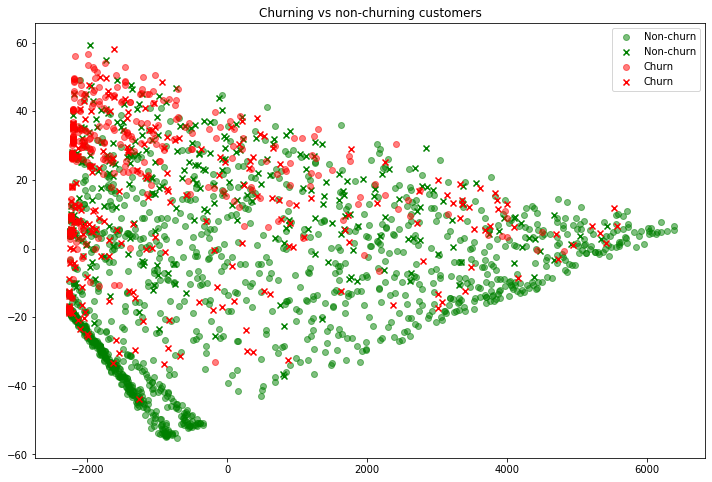

In [ ]:
# Finally, we'll plot all four groups, making those with an incorrect prediction an "x"
fig = plt.figure(figsize=(12, 8))
plt.scatter(x=X_test_nonchurn_correct_pca[:, 0], y=X_test_nonchurn_correct_pca[:, 1], label='Non-churn', color='green', alpha=0.5)
plt.scatter(x=X_test_nonchurn_wrong_pca[:, 0], y=X_test_nonchurn_wrong_pca[:, 1], label='Non-churn', color='green', alpha=1, marker='x')

plt.scatter(x=X_test_churn_correct_pca[:, 0], y=X_test_churn_correct_pca[:, 1], label='Churn', color='red', alpha=0.5)
plt.scatter(x=X_test_churn_wrong_pca[:, 0], y=X_test_churn_wrong_pca[:, 1], label='Churn', color='red', alpha=1, marker='x')

plt.legend()
plt.title('Churning vs non-churning customers');

Note that the color is the actual label. So "x"'s are in the color that they *should* have been predicted, but were not. Thus we can see some interesting customers. For example, in the top-left is a customer who did not churn (green "x"). Our model predicted she would churn since she is "near" many other red points, however she did not. Similarly, those customers on the far-right who churned (red "x") were predicted to churn, yet they didn't. If you worked at this ISP it would be interesting to dive into these outliers and see if there are any obvious patterns about what makes them different. Perhaps they had a poor experience, or were given a special discount? At the same time, remember that the scatter plot above is trying to display 12 dimensional data in 2d, so any conclusions we make from this need to be taken with a grain of salt.

## Exercises

1. We (somewhat randomly) picked some columns for `X_cols` to train our model on. Are these the best columns to use? Try looking through the columns in the original data and seeing if you can come up with some better columns.
2. Try nearest neighbors with different number of neighbors to see if you get better results.
3. Try some different distance metrics for nearest neighbors.
4. PCA down to three dimensions, then plot these in a three dimensional graph (Google it!)
5. Try all of this with new data!